## Hello! 

We have created a diffusion model to mimic the monthly averaged PS, T2m and Precipitation from the CESM-LENS2 data!! 

Here is information on the [CESM2 Large Ensemble](https://www.cesm.ucar.edu/community-projects/lens2). This is a 50 member climate ensemble (lots of compute), that we can now expand to have infinite fields which learn it's prior distribution and determine a postirior conditioned on month and co2 concentration

This repository adapts the [Denoising Diffusion Probabilistic Model](https://arxiv.org/abs/2006.11239) for climate predictions using the CESM2 Large Ensemble (LENS) data. It predicts T2m, Precipitation, and Surface Pressure, conditioned on a given month and CO2 concentration (CO2vmr). This enables climate model forecasts with diffusion-based predictions, improving upon existing methodologies for ensemble predictions.
- The information and code for how I have done this is contained here [https://github.com/WillyChap/denoising-diffusion-pytorch/tree/CESM_Clean]
  - I am more than happy to get into the nuts & bolts if you would like, please ask!


### GOAL of project 🐴
**The goal of this project group is the outline the utility of this emulator.** What I have done is made 500 new ensemble members for every month (JJA and DJF) at every CO2 concentration! A wealth of data! 

Now it is our job to come up with some purpose for this data. Here are some of my ideas:

- does the emulator represent the warming trend well?
- what is the minimum baseline for this to be useful?
  - do we need any post-processing? 
- Does this system represent internal variability well (i.e. the ENSO teleconnection)?
  - what does this say about the change in the ENSO connection?
- Is internal variability changing? -- I see a narrowing on the Feb internal variability.
- Can we increase our understanding of climate change emergence signals?
- What can we learn about extreme events?
- Where are the structural biases / differences? 

If you would like to know more about diffusion modeling, I highly recommend that you take this course!: 
- https://www.youtube.com/watch?v=8mxCNMJ7dHM&list=PL0H3pMD88m8XPBlWoWGyal45MtnwKLSkQ

For a primer on general machine learning watch this: 
- https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

I have placed a few papers here which assess emergence and extremes, feel free to add to this library! 📚
- https://drive.google.com/drive/folders/1MAK1BRPGJSSQaQnEy0atlhI4kWq_510T?usp=drive_link

In [1]:
import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle
import xskillscore as xs
from eofs.xarray import Eof

import os
import cartopy.crs as ccrs

import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

ERROR 1: PROJ: proj_create_from_database: Open of /users_home/training/u12/.conda/envs/diff-analysis-2024b/share/proj failed


## File Structure 

The Files are arranged by Month and CO2 value (PPM), SAMPLES are the ensemble members:

In [2]:
data_path = '/users_home/training/data/Group_01/Ensembles'
file_name = 'samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc'

fp = f'{data_path}/{file_name}'
DS = xr.open_dataset(fp)
DS

<xarray.Dataset> Size: 332MB
Dimensions:  (samples: 500, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * samples  (samples) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    PS       (samples, lat, lon) float32 111MB ...
    PRECT    (samples, lat, lon) float32 111MB ...
    TREFHT   (samples, lat, lon) float32 111MB ...

## Useful Functions I have written for you

In [3]:
def plot_ENSO_NA(slopes_diffy):
    levels = list(np.arange(-2.7, 2.75, .05))
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    ax.set_extent([120, 300, -35, 35], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = slopes_diffy['TREFHT'].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: TREFHT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()

def plot_ENSO_NA_diff(slopes_diffy1, slopes_diffy2):
    levels = list(np.arange(-.7, .75, .05) * 1e-8)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    # ax.set_extent([120, 300, -10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = (slopes_diffy1['PRECT']-slopes_diffy2['PRECT']).plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: PRECT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy1['PS']['lon'], slopes_diffy1['PS']['lat'], slopes_diffy1['PS']-slopes_diffy2['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()
    
def compute_regression_slopes(DS, vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240)):
    """
    Compute the regression slopes of each variable (PS, PRECT, TREFHT) with respect to the mean of TREFHT
    over a specified region.

    Parameters:
    DS (xarray.Dataset): The dataset containing the variables.
    region_lat (tuple): Latitude bounds for selecting the region (default: (-5, 5)).
    region_lon (tuple): Longitude bounds for selecting the region (default: (190, 240)).

    Returns:
    dict: A dictionary containing the slope datasets for each variable (PS, PRECT, TREFHT).
    """
    
    # Step 1: Select the mean of TREFHT over the specified region
    trefht_mean = DS[vardo].sel(lat=slice(*region_lat), lon=slice(*region_lon)).mean(dim=['lat', 'lon'])
    
    # Step 2: Demean the independent variable (TREFHT)
    trefht_mean_demeaned = trefht_mean - trefht_mean.mean(dim='samples')
    
    # Step 3: Loop over each variable and compute the slope at each (lat, lon) point
    regression_slopes = {}
    for var_name in ['PS', 'PRECT', 'TREFHT']:
        # Demean the dependent variable at each (lat, lon) point
        y = DS[var_name]
        y_demeaned = y - y.mean(dim='samples')
        
        # Compute the slope (cov(y, x) / var(x)) at each (lat, lon) point
        slope = (y_demeaned * trefht_mean_demeaned).mean(dim='samples') / (trefht_mean_demeaned ** 2).mean(dim='samples')
        
        # Store the slope result for this variable
        regression_slopes[var_name] = slope
    
    return regression_slopes


def closest_co2vmr_year(co2vmr, FNS):

    closest_diff = np.inf  # Initialize with a large value
    closest_time = None
    closest_file = None
    
    # Dictionary to store the time data from each file
    dict_times = {}

    for fn in FNS:
        # Open the dataset once per file
        CESM_LE = xr.open_dataset(fn)
        timers = CESM_LE['time'].values
        co2vmr_values = CESM_LE['co2vmr'].values

        # Store the time information in a dictionary for later retrieval
        dict_times[fn] = timers

        # Calculate the absolute difference for the CO₂ VMR values in this file
        abs_diff = np.abs(co2vmr_values - co2vmr)

        # Find the index of the minimum difference in this file
        min_index = np.argmin(abs_diff)

        # Update if the current file has a closer CO₂ VMR value
        if abs_diff[min_index] < closest_diff:
            closest_diff = abs_diff[min_index]
            closest_time = timers[min_index]
            closest_file = fn
            print('min dist:', abs_diff[min_index])

    # Return the year, month, and file name of the closest match
    return closest_time.year, closest_time.month, closest_file

def extract_closest_co2vmr_data(co2vmr, mt, var, FNS):
    """
    Extract data for the given variable where CO₂ VMR is closest to the target value for each file.
    
    Parameters:
    - co2vmr: The target CO₂ VMR value (float).
    - var: The variable name to extract (str).
    - FNS: List of file paths to NetCDF datasets (list of strings).
    
    Returns:
    - xarray.DataArray: DataArray containing the stacked data across all files, with dimensions 'time', 'lat', and 'lon'.
    """
    dats_list = []
    closest_index_list = []
    for fn in FNS:
        # Open the dataset
        CESM_LE = xr.open_dataset(fn)
        
        # Select March data (since CESM files are 1 month forward, we're using month == 3)
        feb_data = CESM_LE.where(CESM_LE['time.month'] == mt, drop=True)
        
        # Get the CO2 VMR values
        co2vmr_values = feb_data['co2vmr'].values
        
        # Calculate the absolute difference between the current CO₂ VMR values and the target
        abs_diff = np.abs(co2vmr_values - co2vmr)
        
        # Find the index of the minimum difference
        closest_index = np.argmin(abs_diff)
        closest_index_list.append(closest_index)
        # Extract the corresponding data point for the given variable at the closest CO₂ VMR
        dats_do = feb_data.isel(time=closest_index)[var].values
        
        
        # Append this data to the list
        dats_list.append(dats_do)
    
    # Stack the list of data arrays into a new dimension ('time')
    dats_stack = np.stack(dats_list, axis=0)
    
    # Get lat, lon, and time coordinates (assuming they are consistent across all files)
    lat = feb_data['lat'].values
    lon = feb_data['lon'].values
    times = np.arange(len(FNS))  # Length = 50 (members 0-49) A new "time" dimension, you could modify this if actual time is needed.
    
    # Create an xarray DataArray from the stacked data
    dats_da = xr.DataArray(dats_stack, dims=['time', 'lat', 'lon'], coords={'time': times, 'lat': lat, 'lon': lon})
    
    return dats_da.to_dataset(name=var) , closest_index_list


def concat_files_by_month(month_get, file_pattern):
    """
    Concatenate datasets along a 'samples' dimension, selecting data from a specific month.

    Parameters:
    month_get (int): The month to filter by (e.g., 2 for February).
    file_pattern (str): The glob pattern for the input NetCDF files.

    Returns:
    xarray.Dataset: Concatenated dataset along the 'samples' dimension.
    """
    # Step 1: Get the list of files
    FNS = sorted(glob.glob(file_pattern))

    # Step 2: Create an empty list to hold the filtered datasets
    datasets = []

    # Track the running count of samples
    sample_counter = 0

    # Step 3: Loop over each file and load the dataset, selecting only data for the given month
    for fps in FNS:
        # Open the dataset
        # print(fps)
        DS = xr.open_dataset(fps)

        # Select only data from the specified month
        mo_g = month_get+1

        if mo_g == 13:
            mo_g = 1
        
        DS_feb = DS.sel(time=DS['time.month'] == mo_g)

        # Determine the number of time steps in the current dataset
        n_samples = DS_feb.sizes['time']

        # Replace the 'time' dimension with 'samples' and increment the sample index
        DS_feb = DS_feb.rename({'time': 'samples'})  # Rename 'time' to 'samples'

        # Assign a new 'samples' coordinate, starting from the running sample counter
        DS_feb = DS_feb.assign_coords(samples=(sample_counter + np.arange(n_samples)))

        # Update the sample counter for the next dataset
        sample_counter += n_samples

        # Append the modified dataset to the list
        datasets.append(DS_feb)

    # Step 4: Concatenate along the new "samples" dimension
    DS_concat = xr.concat(datasets, dim='samples')

    return DS_concat

def get_data(momo,flag=False):
    FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month{momo:02}*.nc'))
    # print(FNS[0])
    # print("\n")
    # print(FNS[1])
    mea_trend = []
    std_trend = []
    all_mea_trend ={}
    all_mea_file_paths = {}
    
    lens_mea_trend = []
    lens_std_trend = []
    all_lens_mea_trend ={}
    all_lens_file_paths = {}
    all_lens_closest_indexes = {}
    
    
    for ee,fn in enumerate(FNS):
        print('doing:',ee+2015,fn)
        DS = xr.open_dataset(fn)
        if(flag==True):
            DS = DS.sel(lat=slice(-5,5),lon=slice(190,240)) #lon=slice(120,170)
        
        lat = DS['lat']
        # Calculate weights: cos(lat) in radians
        weights = np.cos(np.deg2rad(lat))
    
        tmean = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','samples'])
        mea_trend.append(tmean.values)
    
        all_mea_trend[ee] = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values
        all_mea_file_paths[ee] = fn
        
        DDS = xs.resample_iterations_idx(DS['TREFHT'], 50, "samples") 
        std_trend.append(DDS.sel(samples=slice(0,50)).weighted(weights).mean(dim=['samples','lat','lon']).std('iteration'))
    
        #now for the LENS:
        #1. find files:
        co2vmr = float(fn.split('co2')[-1].split('_')[0])
        print(co2vmr)
        FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/LENS/*1001.001*.nc'))
        
        yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
        
        
    
        if mt != ((momo+1)%12):
            print('NOOOOOO!--- an error has occurred')
        
        FNS_year = sorted(glob.glob(f'//users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))
        
        results_da1, closest_index_list = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
        
        #### SAVE THE PATHS
        all_lens_file_paths[ee] = FNS_year
        all_lens_closest_indexes[ee] = closest_index_list
        
        if(flag==True):
            results_da1 = results_da1.sel(lat=slice(-5,5),lon=slice(190,240))
        
        tmean_lens = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','time'])
        lens_mea_trend.append(tmean_lens.values)
    
        all_lens_mea_trend[ee] = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values
        DDS_lens = xs.resample_iterations_idx(results_da1['TREFHT'], 50, "time") 
        lens_std_trend.append(DDS_lens.weighted(weights).mean(dim=['time','lat','lon']).std('iteration'))
        
    return all_mea_trend, all_lens_mea_trend, all_mea_file_paths, all_lens_file_paths, all_lens_closest_indexes

def get_statistics(paths):
    X_means = []
    X_all = []
    X_var = []
    
    for path in paths:    
        x = np.load(path,allow_pickle=True).item()
        x_means = []
        x_all = dict()
        x_var = []
        for key, value in x.items():
            media = np.mean(value)
            std = np.std(value)
            x_means.append( media )
            x_var.append( std )
            x_all[key] = value 
        
        x_means = np.array(x_means)
        x_var = np.array(x_var)
    
        X_means.append(x_means)
        X_all.append(x_all)
        X_var.append(x_var)
    
    return X_means, X_var, X_all

def plot_ENZO(X,Y,ax,title):
    colors = ['g','m','b']
    labels = ['Dec','Jan','Feb']
    for i in range(len(X)):
        x_means , x_var = X[i],Y[i] #X_means[i] , X_var[i]
        ax.fill_between(range(0,len(x_means)),x_means - x_var,x_means + x_var, 
                        alpha = 0.12,color=colors[i])
        ax.plot(x_means,color=colors[i],label=labels[i])
    ax.legend(fontsize=15)
    ax.grid(linestyle='--',alpha=0.5)
    ax.set_title(title,fontsize=18)

def get_snapshot_Lens(paths,closest_inds,month,picked_year,picked_index):
    mt = (month+1)%12
    path = paths[picked_year][picked_index]
    index_to_get = closest_inds[picked_year][picked_index]
    DS  = xr.open_dataset(path)
    DS = DS.where(DS['time.month'] == mt, drop=True)
    DS = DS.isel(time=index_to_get)
    return DS


def get_snapshot_Diff(paths,month,picked_year,picked_index):
    DS  = xr.open_dataset(paths[picked_year])
    DS = DS.sel(samples=picked_index)
    return DS

def evaluate_anomalies(months,Dataset_Nino,Dataset_Global):
    ANOMALIES = []
    before_removing_ensemble_mean = []
    for ii, month in enumerate(months):
        data_month = Dataset_Nino[ii]
        means = Dataset_Global[ii] 
    
        anomalies = dict()
        for key,value in data_month.items():
             anomalies[key] = data_month[key] - means[key] 
            
        mean_anomaly = [np.mean(x) for x in anomalies.values()] 
        for key,value in data_month.items():
            anomalies[key] = anomalies[key] - mean_anomaly[key]
            
        ANOMALIES.append(anomalies)
        before_removing_ensemble_mean.append(mean_anomaly)
    return ANOMALIES, before_removing_ensemble_mean
    
# def evaluate_anomalies(months,Dataset_Nino,Dataset_Global):
#     ANOMALIES = []
#     before_removing_ensemble_mean = []
#     for ii, month in enumerate(months):
#         data_month = Dataset_Nino[ii]
#         means = Dataset_Global[ii] 
    
#         anomalies = dict()
#         for key,value in data_month.items():
#              anomalies[key] = data_month[key] - means[key] 
            
#         mean_anomaly = [np.mean(x) for x in anomalies.values()] 
#         for key,value in data_month.items():
#             anomalies[key] = anomalies[key] - mean_anomaly[key]
            
#         ANOMALIES.append(anomalies)
#         before_removing_ensemble_mean.append(mean_anomaly)
#     return ANOMALIES, before_removing_ensemble_mean

## Lets look at comparison to the global warming trend signal for a specific month!: 

- the LENS data is made here: /glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/

In [4]:
# # %%time

# #this gets all the file paths: 


# momo = 12
# FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month{momo:02}*.nc'))
# ee = 0
# fn = FNS[30]
# co2vmr = float(fn.split('co2')[-1].split('_')[0])
# FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/LENS/*1001.001*.nc'))
# print(fn)
# print(co2vmr)
# yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
# print(yt,mt,fout)
# FNS_year = sorted(glob.glob(f'//users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))

# fn = FNS_year[0]
# # Open the dataset
# CESM_LE = xr.open_dataset(fn)
        
# CESM_LE

# # Select March data (since CESM files are 1 month forward, we're using month == 3)
# feb_data = CESM_LE.where(CESM_LE['time.month'] == mt, drop=True)
# feb_data

#  # # Get the CO2 VMR values
# co2vmr_values = feb_data['co2vmr'].values
# feb_data
# # # Calculate the absolute difference between the current CO₂ VMR values and the target
# abs_diff = np.abs(co2vmr_values - co2vmr)
# # # Find the index of the minimum difference
# closest_index = np.argmin(abs_diff)

#         # closest_index_list.append(closest_index)
#         # # Extract the corresponding data point for the given variable at the closest CO₂ VMR
# dats_do = feb_data.isel(time=closest_index)['TREFHT'].values

#         # print('this is the index!!!!', closest_index)
# print(len(FNS_year) )
# CESM_LE
# print(mt)

In [5]:
# moms = [12,1,2]
# months = ["Dec","Jan","Feb"]

#for ii,momo in enumerate(moms):
    # all_mea_trend, all_lens_mea_trend, all_mea_file_paths, all_lens_file_paths, all_lens_closest_indexes = get_data(momo,flag=False)
    # np.save(months[ii]+"_Global_Diff_Trend",all_mea_trend)
    # np.save(months[ii]+"_Global_Lens_Trend",all_lens_mea_trend)

    #all_mea_trend, all_lens_mea_trend, all_mea_file_paths, all_lens_file_paths, all_lens_closest_indexes = get_data(momo,flag=True)
    # np.save(months[ii]+"_Nino_190240_Diff_Trend",all_mea_trend)
    # np.save(months[ii]+"_Nino_190240_Lens_Trend",all_lens_mea_trend)
    # np.save(months[ii]+"_paths_Diff",all_mea_file_paths)
    # np.save(months[ii]+"_paths_Lens",all_lens_file_paths)
    # np.save(months[ii]+"_ClosestIndex_Lens",all_lens_closest_indexes)

In [6]:
### Load the Data
folder = './'
months = ["Dec","Jan","Feb"]

# Nino_Lens_Paths = [folder+'/'+x+'_Nino_Lens_Trend.npy' for x in months]
# Nino_Diff_Paths = [folder+'/'+x+'_Nino_Diff_Trend.npy' for x in months]

# Nino_Lens_Paths_NewZone = [folder+'/'+x+'_Nino_190240_Lens_Trend.npy' for x in months]
# Nino_Diff_Paths_NewZone = [folder+'/'+x+'_Nino_190240_Diff_Trend.npy' for x in months]
Nino_Lens_Paths_NewZone = [folder+'/'+x+'_Nino_NEW_Lens_Trend.npy' for x in months]
Nino_Diff_Paths_NewZone = [folder+'/'+x+'_Nino_NEW_Diff_Trend.npy' for x in months]

# Global_Lens_Paths = [folder+'/'+x+'_Global_Lens_Trend.npy' for x in months]
# Global_Diff_Paths = [folder+'/'+x+'_Global_Diff_Trend.npy' for x in months]

In [7]:
# Nino_means_Diff , Nino_var_Diff, Nino_all_Diff = get_statistics(Nino_Diff_Paths)
# Nino_means_Lens , Nino_var_Lens, Nino_all_Lens = get_statistics(Nino_Lens_Paths)

Nino_NewZone_means_Diff, Nino_NewZone_var_Diff, Nino_NewZone_all_Diff = get_statistics(Nino_Diff_Paths_NewZone)
Nino_NewZone_means_Lens, Nino_NewZone_var_Lens, Nino_NewZone_all_Lens = get_statistics(Nino_Lens_Paths_NewZone)

# Global_means_Diff , Global_var_Diff, Global_all_Diff = get_statistics(Global_Diff_Paths)
# Global_means_Lens , Global_var_Lens, Global_all_Lens = get_statistics(Global_Lens_Paths)

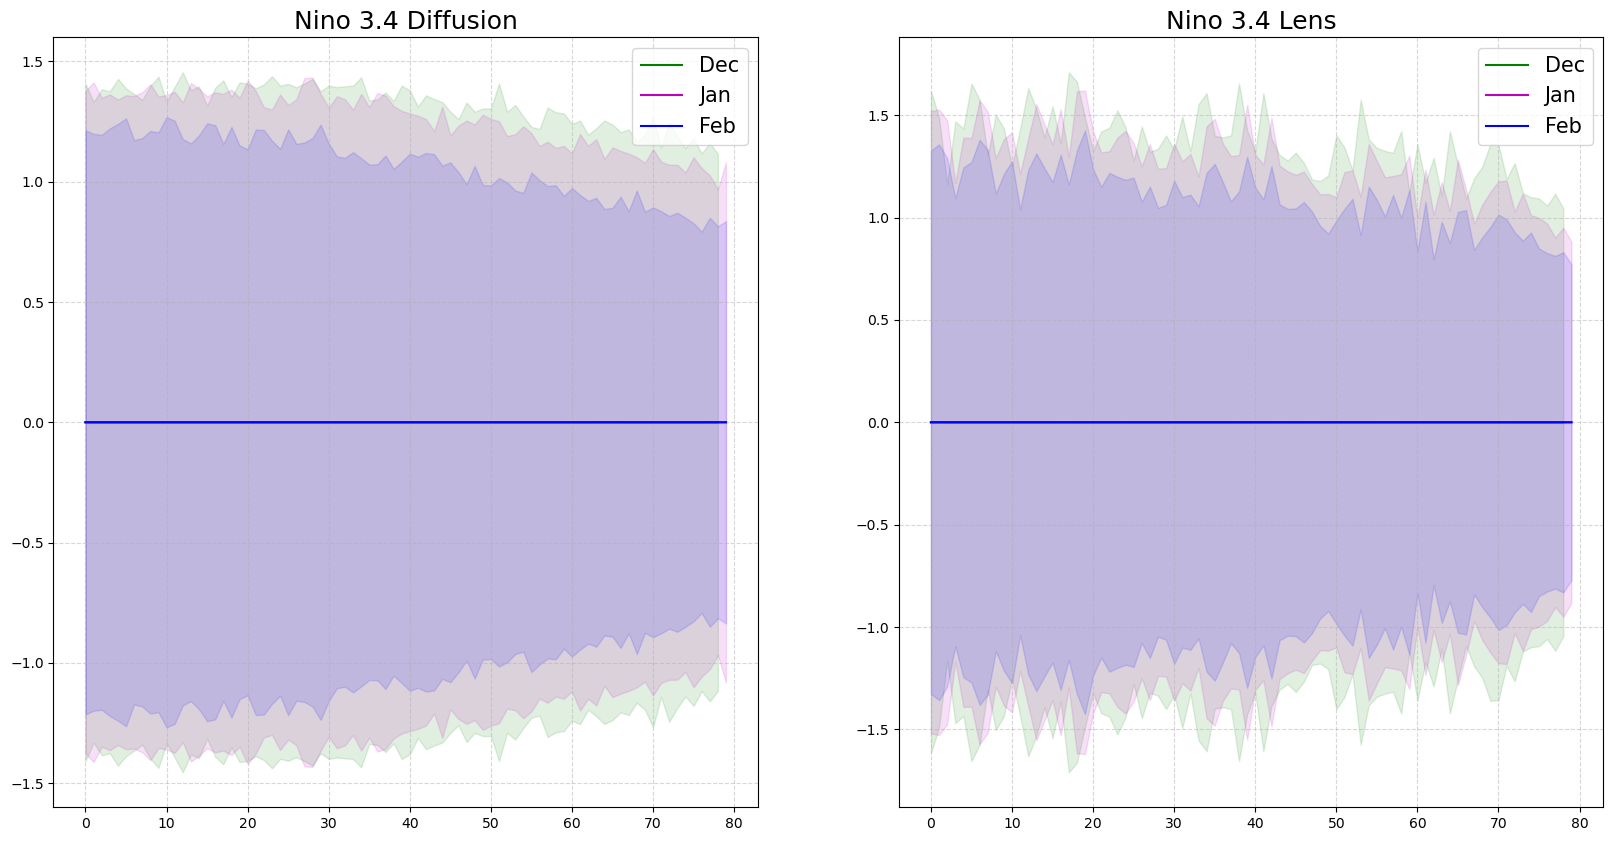

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_ENZO(Nino_NewZone_means_Diff,Nino_NewZone_var_Diff,ax[0],'Nino 3.4 Diffusion')
plot_ENZO(Nino_NewZone_means_Lens,Nino_NewZone_var_Lens,ax[1],'Nino 3.4 Lens')

(0.0, 30.0)

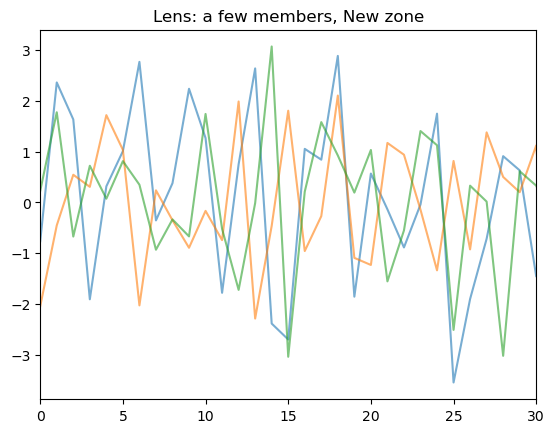

In [9]:
members_NewZone = [ [Nino_NewZone_all_Lens[0][key][j] for key in range(0,len(Nino_NewZone_all_Lens[0]))] for j in range(0,3)]
# members = [ [Nino_all_Lens[0][key][j] for key in range(0,len(Nino_all_Lens[0]))] for j in range(0,3)]

fig , ax = plt.subplots()

for i in range(0,len(members_NewZone)):
    ax.plot(members_NewZone[i],alpha=0.6)

    
#ax.plot(Nino_NewZone_means_Lens[0],color='k')

ax.set_title('Lens: a few members, New zone')
ax.set_xlim(0,30)

In [10]:
# fig, ax = plt.subplots(ncols=2, figsize=(20,10))
# plot_ENZO(Global_means_Diff,Global_var_Diff,ax[0],'Global Diffusion')
# plot_ENZO(Global_means_Lens,Global_var_Lens,ax[1],'Global Lens')

In [10]:
# ANOMALIES_Lens, before_removing_ensemble_Lens = evaluate_anomalies(months,Nino_NewZone_all_Lens,Global_means_Lens)
# ANOMALIES_Diff, before_removing_ensemble_Diff = evaluate_anomalies(months,Nino_NewZone_all_Diff,Global_means_Diff)

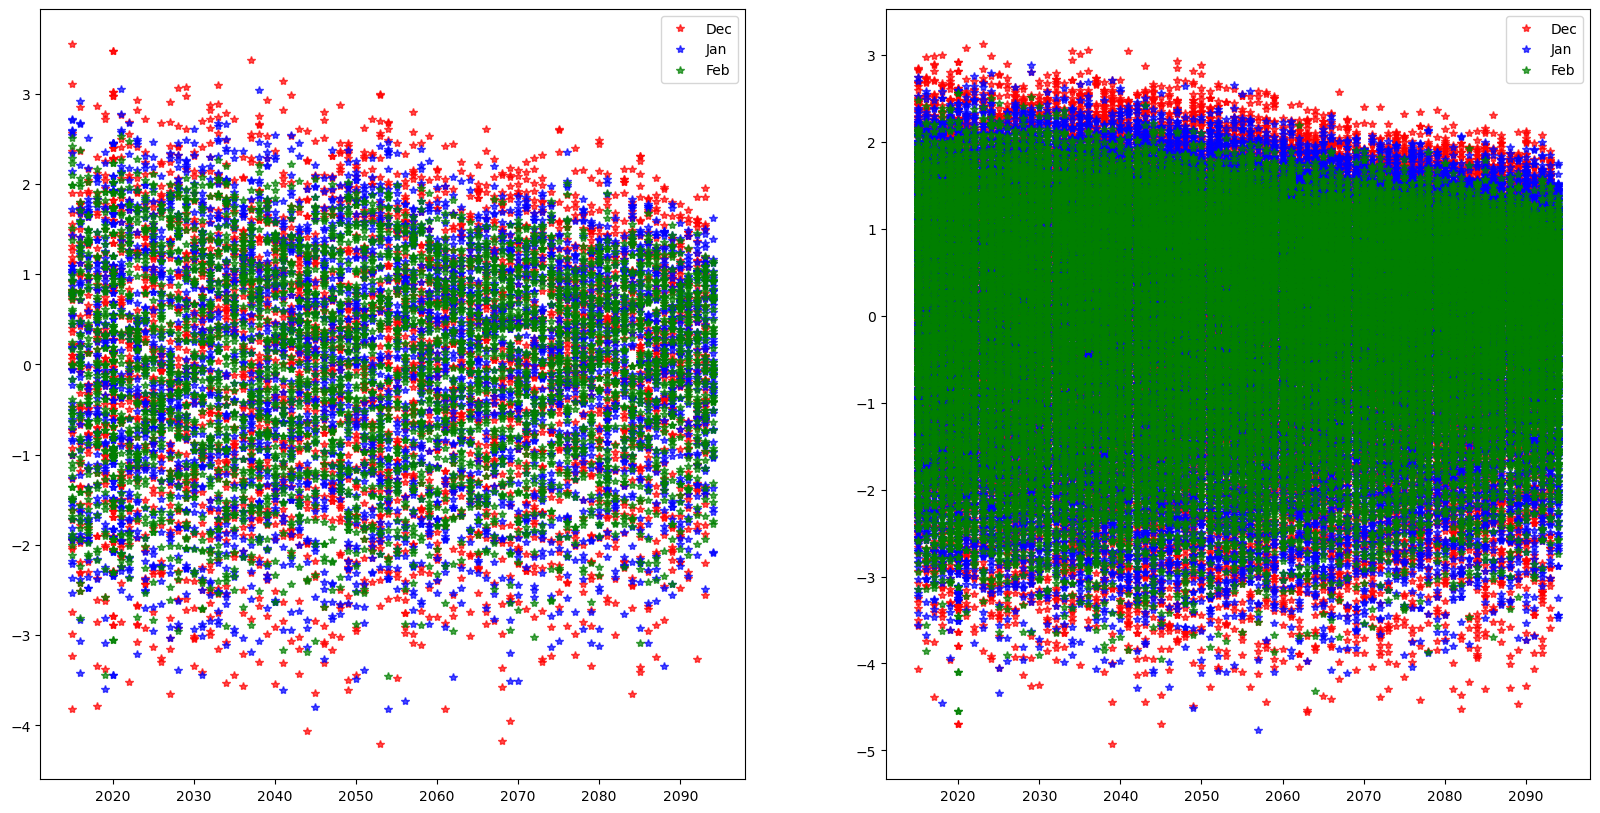

In [11]:
ANOMALIES_Lens = Nino_NewZone_all_Lens
ANOMALIES_Diff = Nino_NewZone_all_Diff


fig, ax = plt.subplots(ncols=2, figsize = (20,10))
colors = ['r','b','g']
for ii, month in enumerate(months): 
    anomalies = ANOMALIES_Lens[ii]
    for key in anomalies.keys():
        ax[0].plot([2015+key]*len(anomalies[0]),anomalies[key],'*', alpha =0.7,color=colors[ii])
        if(key==5):
            ax[0].plot([2015+key]*len(anomalies[0]),anomalies[key],'*', alpha =0.7,color=colors[ii],label=month)

    anomalies = ANOMALIES_Diff[ii]
    for key in anomalies.keys():
        ax[1].plot([2015+key]*len(anomalies[0]),anomalies[key],'*', alpha =0.7,color=colors[ii])
        if(key==5):
            ax[1].plot([2015+key]*len(anomalies[0]),anomalies[key],'*', alpha =0.7,color=colors[ii],label=month)
ax[0].legend()
ax[1].legend()

In [32]:
##### FIX THE MONTH : DECEMBER #####
month = 12
anomalies = ANOMALIES_Lens[0]
paths = np.load("./Dec_paths_Lens.npy",allow_pickle=True).item()
closest_inds = np.load("./Dec_ClosestIndex_Lens.npy",allow_pickle=True).item()
Ensemble_data = np.load("./Dec_EnsembleMeans_Lens.npy",allow_pickle=True).item()
Ensemble_data_PRECT = np.load("./Dec_EnsembleMeans_Precipitation_Lens.npy",allow_pickle=True).item()

all_anomalies = np.concatenate(
    [anomalies[key]  for key in anomalies.keys()]
)

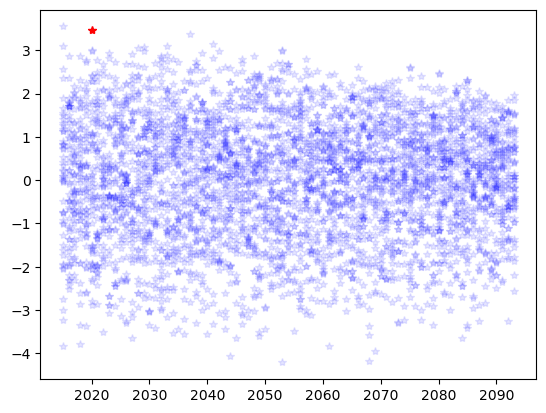

In [13]:
fig, ax = plt.subplots()

for key in anomalies.keys():
    anomalies_adjusted = anomalies[key] 
    ax.plot(
        [2015 + key] * len(anomalies_adjusted), anomalies_adjusted, "*", alpha=0.1, color="b"
    ) 


year = 5
index_max = np.argmax(  abs( anomalies[year] ) )
ax.plot([2015+year],anomalies[year][index_max],'*',color='r')

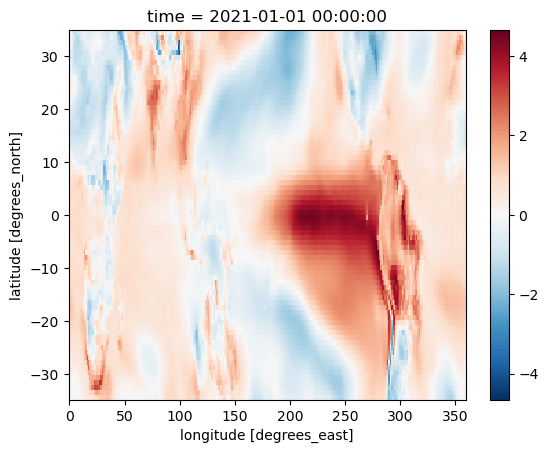

In [14]:
# Plot an ENSO

picked_year = year
picked_index = index_max 
DS = get_snapshot_Lens(paths,closest_inds,month,picked_year,picked_index)
lat_global = DS['lat'].values
lon_global = DS['lon'].values

Ensemble = Ensemble_data[year]
# Create an xarray DataArray from the stacked data
ds = xr.DataArray(Ensemble, dims=['lat', 'lon'], coords={'lat': lat_global, 'lon': lon_global})

diff = DS.TREFHT - ds
diff.sel(lat=slice(-35,35)).plot() #lon=slice(120,290)

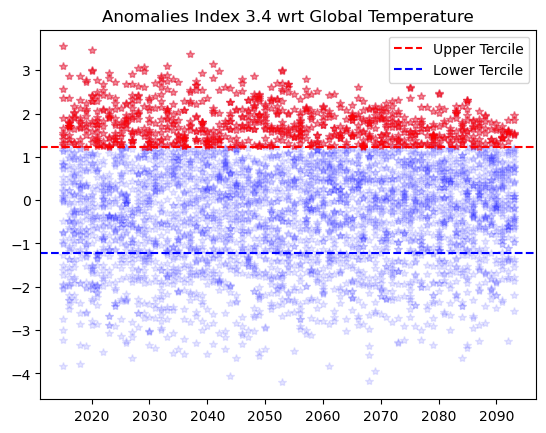

In [17]:
# Plot setup
fig, ax = plt.subplots()
# Plot all ensemble members and highlight anomalies above the upper tercile

for key in anomalies.keys():
    anomalies_adjusted = anomalies[key] 
    ax.plot(
        [2015 + key] * len(anomalies_adjusted), anomalies_adjusted, "*", alpha=0.1, color="b"
    )  # Normal members


    
# # Highlight year and index with max anomaly in red
# ax.plot(
#     [2015 + year],
#     anomalies[year][index_max] ,
#     "*",
#     alpha=0.2,
#     color="r",
# )

# Plot the tercile line
upper_tercile = np.percentile(all_anomalies, 80)  # Upper tercile threshold
lower_tercile = np.percentile(all_anomalies, 20)  # Lower tercile threshold
ax.axhline(y=upper_tercile, color="r", linestyle="--", label="Upper Tercile")
ax.axhline(y=lower_tercile, color="b", linestyle="--", label="Lower Tercile")


anomalies_above = dict()

for key in anomalies.keys():
    anomalies_adjusted = anomalies[key] 

    # Highlight members above the upper tercile
    anomalies_above_tercile = anomalies_adjusted > upper_tercile  # Boolean mask
    anomalies_above[key]=anomalies_above_tercile
    x_coords = np.full(np.sum(anomalies_above_tercile), 2015 + key)  # Match x size to filtered y
    
    ax.plot(
        x_coords, 
        anomalies_adjusted[anomalies_above_tercile],
        "*",
        alpha=0.4,
        color="r",
    )

# Title and legend
ax.set_title("Anomalies Index 3.4 wrt Global Temperature")
ax.legend()
plt.show()

In [18]:
########### LET'S TAKE ALL THE ENSO TOGETHER #############

In [19]:
a = 0
for key , element in anomalies_above.items():
    a = a + np.sum(element)
a

790

In [20]:
# paths = np.load("./Dec_paths_Lens.npy",allow_pickle=True).item()
# closest_inds = np.load("./Dec_ClosestIndex_Lens.npy",allow_pickle=True).item()
# Ensemble_data = np.load("./Dec_EnsembleMeans_Lens.npy",allow_pickle=True).item()
# Ensemble_data_PRECT

data_list = []

for key , element in anomalies_above.items():
    Ensemble = Ensemble_data[key]
    # Create an xarray DataArray from the stacked data
    ds = xr.DataArray(Ensemble, dims=['lat', 'lon'], coords={'lat': lat_global, 'lon': lon_global})
    ds = ds.sel(lat=slice(-20,20),lon=slice(120,290))
    lat_regional = ds['lat'].values
    lon_regional = ds['lon'].values
    
    for index_to_get in range(0,len(element)):
        if(element[index_to_get] == True ):
            DS = get_snapshot_Lens(paths,closest_inds,month,key,index_to_get)
            DS = DS.sel(lat=slice(-20,20),lon=slice(120,290))
            # lat1 = DS['lat'].values
            # lon1 = DS['lon'].values
            diff = DS.TREFHT - ds
            data_list.append( diff.values  )
    print(key)       

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [194]:
# DS = get_snapshot_Lens(paths,closest_inds,month,picked_year,picked_index)
# DS = DS.sel(lat=slice(-20,20),lon=slice(120,290))
# lat = DS['lat'].values
# lon = DS['lon'].values



In [21]:
# Step 1: Preprocess - Flatten the 2D data arrays into 1D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
def flatten_data(data_list):
    """
    Flattens each 2D SST anomaly map into a 1D array and stacks them into a matrix.
    """
    data_matrix = []
    for data in data_list:
        data_matrix.append(data.flatten())
    return np.array(data_matrix)

# Step 2: Load the data and flatten it
# Replace this list with your actual xarray DataArrays
# Example placeholder:
# sst_anomaly_maps = [ds1, ds2, ds3, ...]
data_matrix = flatten_data(data_list)
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to range [0, 1]
data_matrix_normalized = scaler.fit_transform(data_matrix)
# Step 3: K-means Clustering
num_clusters = 3  # Choose the number of ENSO flavors to classify

In [22]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_normalised = KMeans(n_clusters=num_clusters, random_state=42)

In [23]:
clusters = kmeans.fit_predict(data_matrix)  # Fit and get cluster labels
clusters_normalised = kmeans_normalised.fit_predict(data_matrix_normalized)
cluster_centers_rescaled = scaler.inverse_transform(kmeans_normalised.cluster_centers_)

In [24]:
clustered_maps = kmeans.cluster_centers_.reshape(num_clusters, len(lat_regional), len(lon_regional))
clustered_maps_normalised = cluster_centers_rescaled.reshape(num_clusters, len(lat_regional), len(lon_regional))

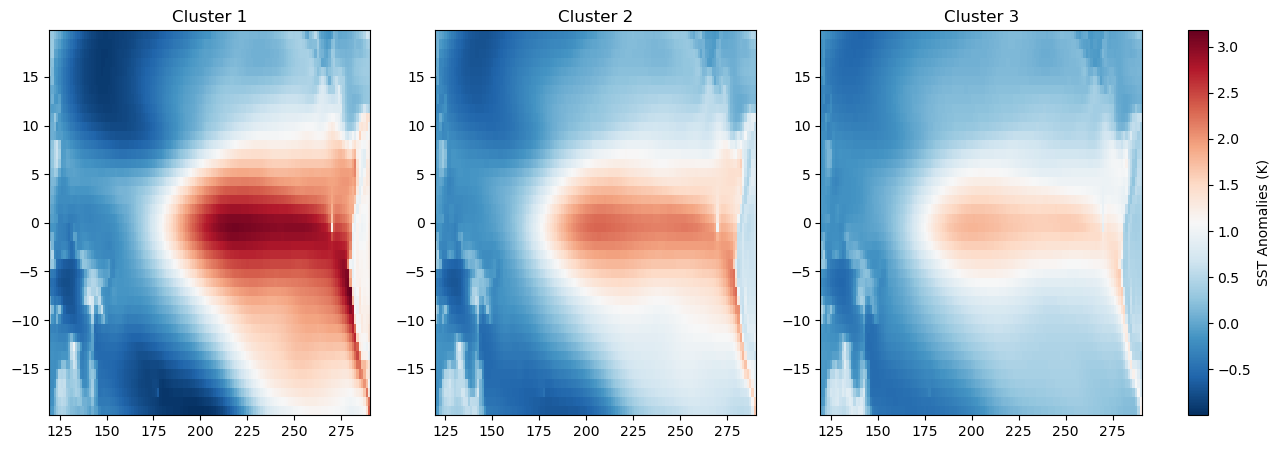

In [25]:
# Step 5: Plot the clustered ENSO flavors
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 5))
vmin, vmax = np.min(clustered_maps), np.max(clustered_maps)

for i, ax in enumerate(axes):
    im = ax.pcolormesh(lon_regional, lat_regional, clustered_maps[i], cmap="RdBu_r", vmin=vmin, vmax=vmax)
    ax.set_title(f"Cluster {i+1}")
    #plt.colorbar(im, ax=ax, orientation="vertical",)
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04, label="SST Anomalies (K)")

#plt.tight_layout()
plt.show()
#fig.savefig('clustering_not_normalised_20.png')

In [200]:
# # Step 5: Plot the clustered ENSO flavors
# fig, axes = plt.subplots(1, num_clusters, figsize=(15, 5))
# vmin, vmax = np.min(clustered_maps), np.max(clustered_maps)

# for i, ax in enumerate(axes):
#     im = ax.pcolormesh(lon, lat, clustered_maps_normalised[i], cmap="RdBu_r", vmin=vmin, vmax=vmax)
#     ax.set_title(f"Cluster {i+1}")
#     #plt.colorbar(im, ax=ax, orientation="vertical",)
# fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04, label="SST Anomalies (K)")

# #plt.tight_layout()
# plt.show()
# #plt.savefig('clustering_not_normalised.png')

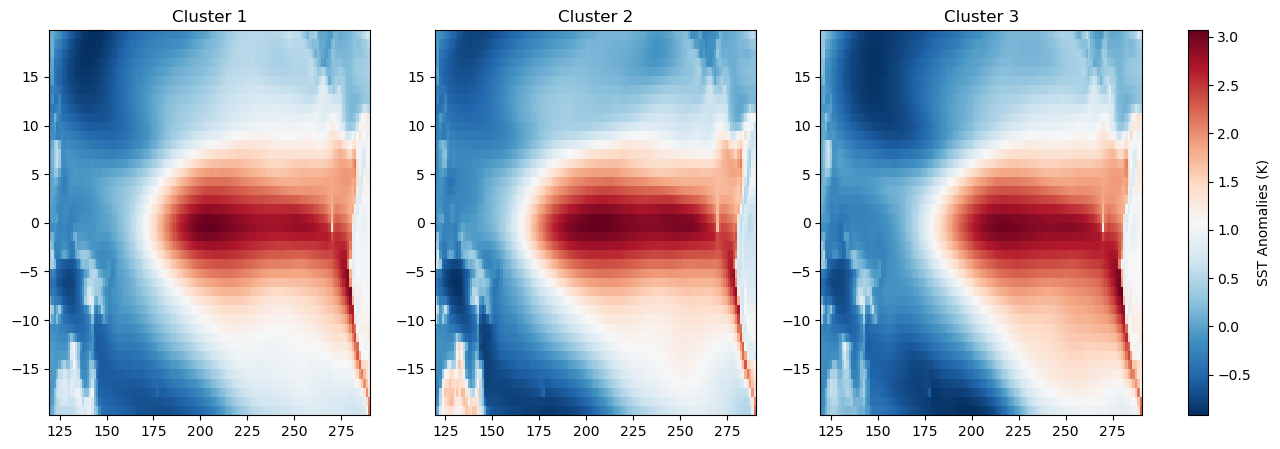

In [27]:
# Step 5: Plot the clustered ENSO flavors
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 5))
vmin, vmax = np.min(clustered_maps), np.max(clustered_maps)

for i, ax in enumerate(axes):
    im = ax.pcolormesh(lon_regional, lat_regional, clustered_maps_normalised[i], cmap="RdBu_r")
    ax.set_title(f"Cluster {i+1}")
    #plt.colorbar(im, ax=ax, orientation="vertical",)
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04, label="SST Anomalies (K)")

#plt.tight_layout()
plt.show()
#fig.savefig('clustering_normalised_20.png')

In [ ]:
######## COMPOSITE ########

In [33]:
Enso_data = [] 
DS = get_snapshot_Lens(paths,closest_inds,month,picked_year,picked_index)
lat = DS['lat'].values
lon = DS['lon'].values
for key , element in anomalies_above.items():
    Ensemble = Ensemble_data[key]
    Ensemble_PRECT = Ensemble_data_PRECT[key]
    # Create an xarray DataArray from the stacked data
    ds = xr.DataArray(Ensemble, dims=['lat', 'lon'], coords={'lat': lat_global, 'lon': lon_global})
    ds_PRECT = xr.DataArray(Ensemble_PRECT, dims=['lat', 'lon'], coords={'lat': lat_global, 'lon': lon_global})
    #ds = ds.sel(lat=slice(-20,20),lon=slice(120,290))
    for index_to_get in range(0,len(element)):
        if(element[index_to_get] == True ):
            DS = get_snapshot_Lens(paths,closest_inds,month,key,index_to_get)
            #DS = DS.sel(lat=slice(-20,20),lon=slice(120,290))
            # lat1 = DS['lat'].values
            # lon1 = DS['lon'].values
            
            Enso_data.append( DS.PRECT - ds_PRECT  )
    print(key)   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [36]:
different_clusters = np.unique( clusters_normalised )
SUMS = []
for value in different_clusters:
    cluster_index = np.where( clusters_normalised == value )[0]
    Sum = Enso_data[cluster_index[0]]#.PRECT
    for x in cluster_index[1:]:
        Sum = Sum + Enso_data[x] / len(cluster_index) #.PRECT
    SUMS.append(Sum)

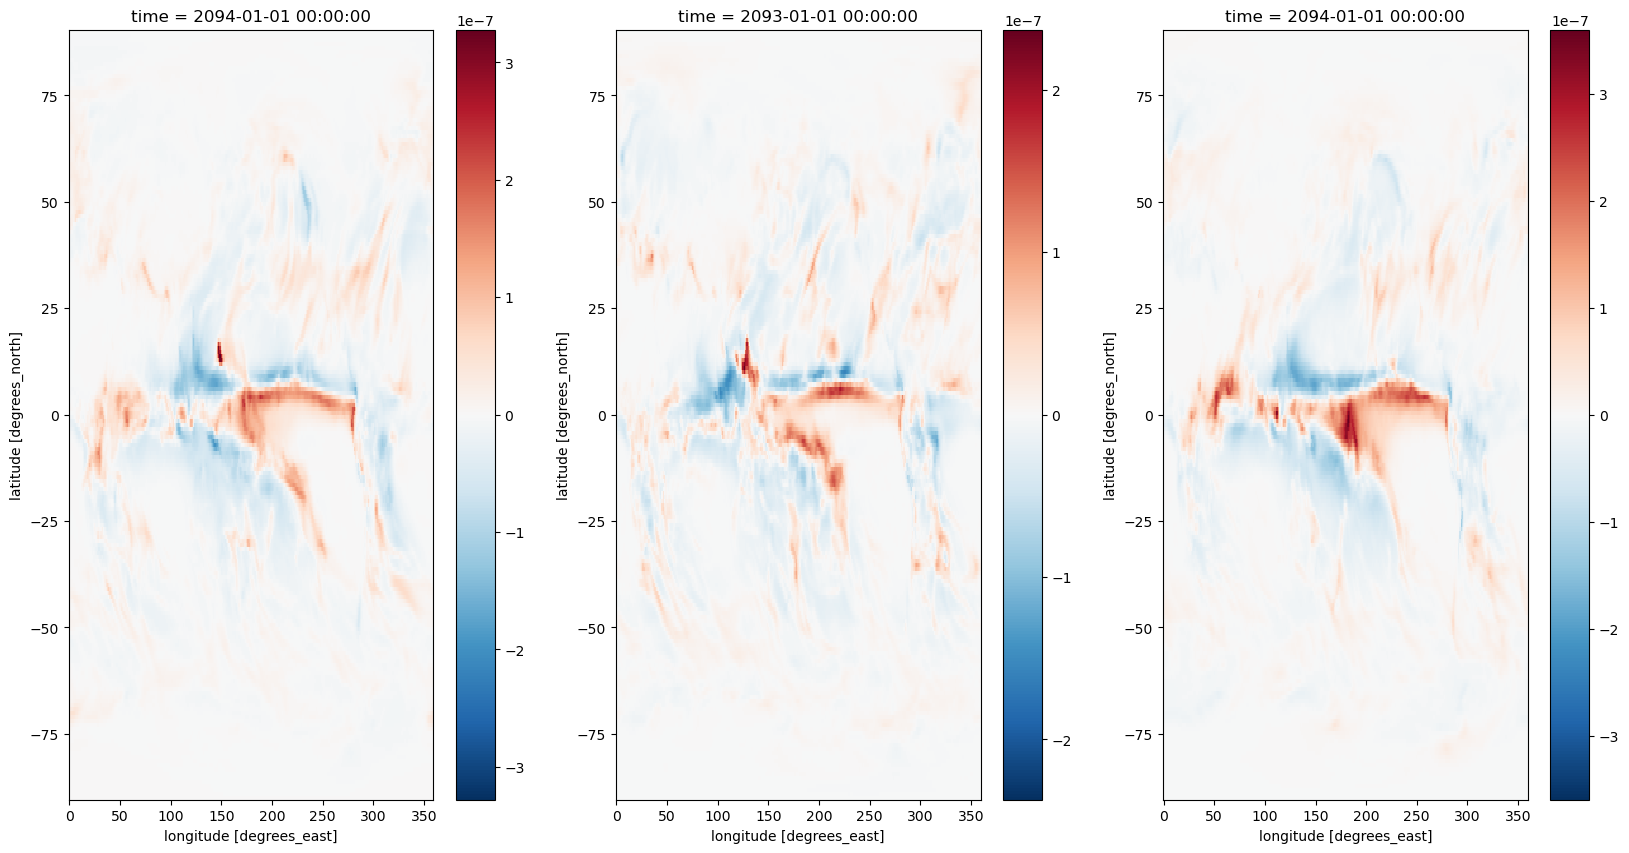

In [38]:
fig, ax = plt.subplots(ncols=3,figsize=(20,10))

for i in range(0,len(SUMS)):
    SUMS[i].plot(ax=ax[i])

2

In [81]:
paths = np.load("data/Jan_paths_Diff.npy",allow_pickle=True).item()
#closest_inds = np.load("data/Jan_ClosestIndex_Lens.npy",allow_pickle=True).item()

month = 12
picked_year = year
picked_index = index_max 
DS = get_snapshot_Diff(paths,month,picked_year,picked_index)

DS 
#slope = compute_regression_slopes(DS.sel(samples=slice(0,500)), vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240))

<xarray.Dataset> Size: 667kB
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    samples  int64 8B 185
Data variables:
    PS       (lat, lon) float32 221kB ...
    PRECT    (lat, lon) float32 221kB ...
    TREFHT   (lat, lon) float32 221kB ...

In [43]:
#mean_anomaly = [np.mean(x) for x in anomalies.values()]   
# year = 38
# index_max = np.argmax(Dec[year])

# fig, ax = plt.subplots()
# for key in anomalies.keys():
#     ax.plot([2015+key]*50,anomalies[key] - mean_anomaly[key],'*', alpha =0.1,color='b')

# ax.plot([2015+year],anomalies[year][index_max] - mean_anomaly[year],'*',color='r')
# #ax.plot(range(2015,2015+len(anomalies)),,'r')
# ax.set_title("Anomalies Index 3.4 wrt Global Temperature: Lens")
# print(2015+year)

In [13]:
paths = np.load("data/Dec_paths_Lens.npy",allow_pickle=True).item()
closest_inds = np.load("data/Dec_ClosestIndex_Lens.npy",allow_pickle=True).item()
month = 12

DS = get_snapshot_Lens(paths,closest_inds,month,year,index_max)
DS = DS.sel(lat=slice(-5,5),lon=slice(190,240))  #lon=slice(120,170)      
lat = DS['lat']
# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))
print( DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values  )
print( Dec[year][index_max] )

303.7033942902509
303.7033942902509


Text(0.5, 1.0, 'Anomalies Index 3.4 wrt Global Temperature: Diffusion')

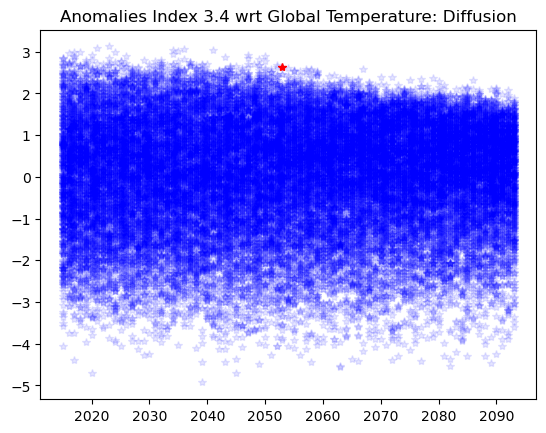

In [14]:
#### Get Anomalies for Diffusion

Dec = Nino_NewZone_all_Diff[0]
means = Global_means_Diff[0] 

anomalies = dict()
for key,value in Dec.items():
    anomalies[key] = Dec[key] - means[key] 
    
mean_anomaly = [np.mean(x) for x in anomalies.values()]
year = 38
index_max = np.argmax(Dec[year])

fig, ax = plt.subplots()
for key in anomalies.keys():
    ax.plot([2015+key]*500,anomalies[key] - mean_anomaly[key],'*', alpha =0.1,color='b')

ax.plot([2015+year],anomalies[year][index_max] - mean_anomaly[year],'*',color='r')
#ax.plot(range(2015,2015+len(anomalies)),,'r')
ax.set_title("Anomalies Index 3.4 wrt Global Temperature: Diffusion")

In [15]:
month = 12
FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month{month:02}*.nc'))
len(FNS)

79

In [21]:
paths = np.load("data/Dec_paths_Diff.npy",allow_pickle=True).item()
DS = get_snapshot_Diff(paths,month,year,index_max)

DS = DS.sel(lat=slice(-5,5),lon=slice(190,240))  #lon=slice(120,170)      
lat = DS['lat']
# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))
print( DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values  )
print( Dec[year][index_max] )

303.85743239751156
303.85743239751156


In [120]:
# max_value = 0

# X = X_anomalies_Lens[0]
# for key in X.keys():
#     M = max( X[key] )
#     if(M > max_value):
#         index_within_dict = list(X[key]).index(M)
#         index_key = key
#         max_value = M
        

2053 28


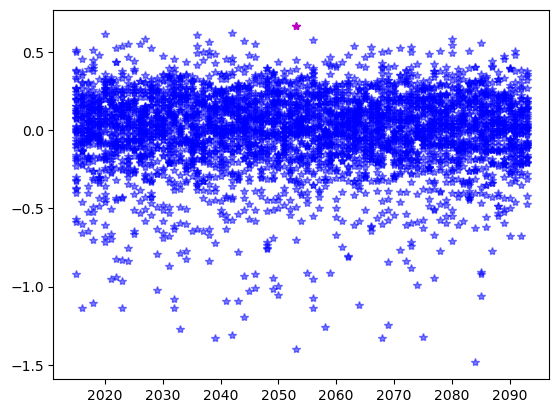

In [121]:
fig, ax = plt.subplots()
for key in X_anomalies_Lens[0].keys():
    ax.plot([2015+key]*50,X_anomalies_Lens[0][key],'*', alpha =0.5,color='b')
    
ax.plot(2015+index_key,X_anomalies_Lens[0][index_key][index_within_dict],'m*') 
print(2015+index_key, index_within_dict)

In [132]:
path_maximum = all_lens_file_paths[index_key][index_within_dict]
time = all_lens_closest_indexes[index_key][index_within_dict]

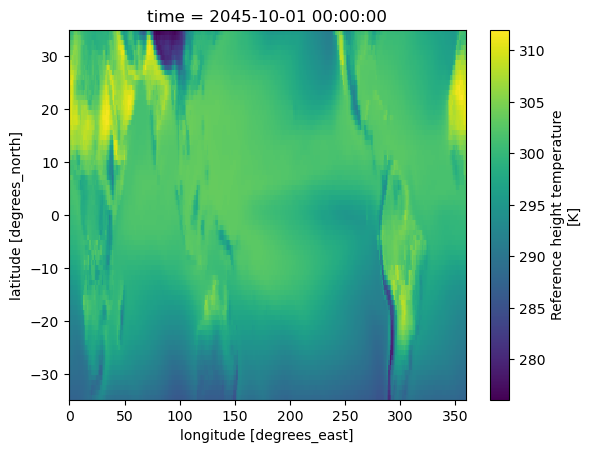

In [141]:
DS = xr.open_dataset(path_maximum)
DS.isel(time=time).sel(lat=slice(-35,35)).TREFHT.plot()

In [80]:
# X_anomalies_Lens

In [23]:
len(sorted(glob.glob('/users_home/training/data/Group_01/LENS/*204501-205412.nc')))

ds_list = []
year = 2053
month = 12
for fn in sorted(glob.glob('/users_home/training/data/Group_01/LENS/*204501-205412.nc')): 

    DS = xr.open_dataset(fn)
    ind_years = np.where(DS['TREFHT']['time.year']==year)[0]
    ind_years
    ind_months =  np.where(DS.isel(time = np.where(DS['TREFHT']['time.year']==2053)[0])['time.month']==1)[0]
    ind_months
    
    DSyears = DS.isel(time=ind_years)
    DSyears_months = DSyears.isel(time=ind_months)
    DSyears_months
    ds_list.append(DSyears_months)

#np.where(DS.isel(time = np.where(DS['TREFHT']['time.year']==2053)[0])['time.month']==1)